# 02. Model Scratch
Workspace for testing models on the fly

### Import Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn import svm

In [ ]:
data_df = None
if os.path.isfile("data/data.pkl"):
    data_df = pd.read_pickle("data/data.pkl")
else:
    print("Load Data")
data_df.head()

### Test TBI Classification Alone

In [ ]:
# tbi_df = data_df[data_df["Study"] == "TBI"]
# tbi_evc = np.vstack(tbi_df["EVC"])
# tbi_class = np.where(tbi_df["Diagnosis"] == "POS", 1, 0)
# print(np.shape(tbi_evc))
# tbi_df.head()

tbi_df = data_df[(data_df["Study"] != "TBI") & (data_df["Harmonized"].notna())]
tbi_evc = np.vstack(tbi_df["EVC"])
tbi_class = np.where(tbi_df["Diagnosis"] == "AD", 1, 0)
print(np.shape(tbi_evc))
tbi_df.head()

0.36086824529447487
0.5412416514875531
0.4598360655737705
0.5721615057680631
0.3059502125075895
0.36138433515482693
0.3470248937462052
0.5212811171827565
0.35204918032786886
0.3681693989071038
0.3196417729204615
0.6146933819064967
0.5369459623557984
0.34456587735276256
0.3559198542805101
0.5413782635094111
0.352504553734062
0.3521554341226472
0.36123254401942934
0.337037037037037
0.33729508196721314
0.33548876745598055
0.23337887067395266
0.25596539162112936
0.33755312689738926
0.3382817243472981
0.3147692774741955
0.32873406193078325
0.30722525804493017
0.28731026108075286
0.35901639344262304
0.48970856102003646
0.46677292046144503
0.30007589556769887
0.3599574984820887
0.5345173041894353
0.22292046144505162
0.6103825136612022
0.3439283545840924
0.3938372799028537
0.3220704310868246
0.355661809350334
0.5947935640558591
0.3503035822707954
0.34875531268973897
0.3441863995142683
0.4081056466302368
0.46703096539162114
0.3380692167577414
0.5701275045537341
0.34013357619914997
0.33800850030

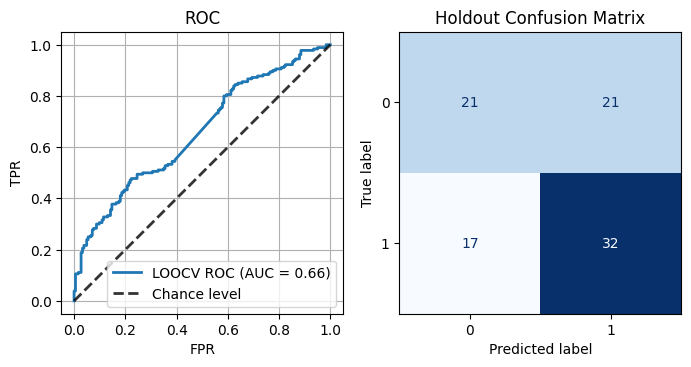

              precision    recall  f1-score   support

           0       0.57      0.51      0.54       183
           1       0.55      0.60      0.57       180

    accuracy                           0.56       363
   macro avg       0.56      0.56      0.56       363
weighted avg       0.56      0.56      0.56       363



In [ ]:
# X is tbi_evc and Y is tbi_class
# clf = svm.SVC(
#     kernel="sigmoid",
#     random_state=42,
#     class_weight="balanced",
#     probability=True,
#     gamma="scale",
# ) 2, 7, 83, 86, 120, 167

from ipywidgets import IntProgress
from IPython.display import display
import time

best_roc_auc = 0.00
state = 1
f = IntProgress(min=0, max=1000)

while state < 150:
    clf = svm.SVC(
        kernel="sigmoid", class_weight="balanced", probability=True, random_state=state
    )
    loo = LeaveOneOut()

    results = []
    for train, test in loo.split(tbi_evc, tbi_class):
        this_fit = clf.fit(tbi_evc[train], tbi_class[train])
        results.append(
            [
                tbi_class[test],
                this_fit.predict_proba(tbi_evc[test])[:, 1],
                this_fit.predict(tbi_evc[test]),
            ]
        )
    results = np.squeeze(results)

    # ROC_AUC
    fpr, tpr, thresholds = roc_curve(results[:, 0], results[:, 1])
    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    # Confusion Matrix
    x_train, x_test, y_train, y_test = train_test_split(
        tbi_evc, tbi_class, random_state=state
    )
    holdout_test = clf.fit(x_train, y_train)

    y_pred = holdout_test.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_roc_auc_data = (fpr, tpr, cm)
        if roc_auc > 0.65:
            break

    state = state + 1
    f.value += 1 

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

ax1.plot(best_roc_auc_data[0], best_roc_auc_data[1], lw=2, label=f"LOOCV ROC (AUC = {best_roc_auc:.2f})")
ax1.plot(
    [0, 1], [0, 1], linestyle="--", lw=2, color="k", label="Chance level", alpha=0.8
)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")
ax1.set_title("ROC")
ax1.legend(loc="lower right")
ax1.grid(True)
ax1.set_aspect("equal", adjustable="box")

disp = ConfusionMatrixDisplay(confusion_matrix=best_roc_auc_data[2], display_labels=clf.classes_)
disp.plot(ax=ax2, cmap=plt.cm.Blues, colorbar=False)
ax2.set_title("Holdout Confusion Matrix")
plt.show()

print(classification_report(tbi_class, results[:, 2]))

In [ ]:
# Hyperparameter Optimization Test

# x_train, x_test, y_train, y_test = train_test_split(tbi_evc, tbi_class, random_state=42)

# svc_params = {
#         'C': np.linspace(1e-7, 10, 10),
#         'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
#         'tol': np.linspace(1e-5, 0.1, 5),
#         'gamma': np.linspace(1e-5, 10, 10),
#         'coef0': np.linspace(1e-2, 2, 3)
#     }

# gs_results = GridSearchCV(svm.SVC(random_state=42), svc_params, cv=LeaveOneOut(), verbose=True).fit(x_train, y_train)
# results = pd.DataFrame(gs_results.cv_results_)

# results = results.loc[:, ('rank_test_score', 'mean_test_score', 'params')]
# results.sort_values(by='rank_test_score', ascending=True, inplace=True)

# score = results['mean_test_score'].iloc[0]
# params = results['params'].iloc[0]

# print(f'Best score for GridSearchCv is {score:.3f}')
# print(f'Params: {params}')